# MNIST example with Subspace Method

In the example code of this tutorial, we assume for simplicity that the following symbols are already imported.

In [1]:
import sys, os, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
sys.path.insert(0, os.pardir)
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score

from scipy.stats import randint as sp_randint

from cvt.models import SubspaceMethod

In this tutorial section, we will learn how to train a simple subspace based classifier to classify images of hand-written digits in the popular MNIST dataset. To show the effectiveness of this method we will compare the results to a sklearn KNN classifier.

The MNIST dataset contains 50,000 training examples and 10,000 test examples. Each example is a set of a 28 x 28 greyscale image and a corresponding class label. Since the digits from 0 to 9 are used, there are 10 classes for the labels.

We will conduct the procedure in the following steps.

1. Prepare a dataset
2. Train the SV classifier
3. Train the SM classifier
4. Improving results
5. In depth comparison


## 1. Prepare a dataset

Sklearn provides an (experimental) API to fetch datasets from openml by name or dataset id.

In [2]:
# Fetch the MNIST data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=10000, test_size=2000)

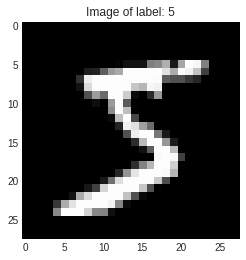

In [3]:
# Display an example from the MNIST dataset.
# `x` contains the input image array and `t` contains that target class
# label as an integer.

x, t = X[0], y[0]
plt.style.use('seaborn-dark')
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.title(f'Image of label: {t}')
plt.show()

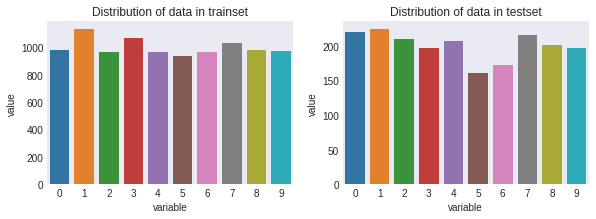

In [4]:
from scipy.constants import golden as g_ratio
from pandas import DataFrame as DF
from collections import Counter

# Display the distribution of the testset and trainset
# Take note of the slight inbalance maybe?
fig =  plt.figure(figsize=(6*g_ratio, 3))

sns.barplot(x="variable", y="value", data=DF(Counter(y_train), index=['val']).melt(), ax=fig.add_subplot(121))
plt.title('Distribution of data in trainset')

sns.barplot(x="variable", y="value", data=DF(Counter(y_test), index=['val']).melt(), ax=fig.add_subplot(122))
plt.title('Distribution of data in testset')
plt.show()

## 2. Train a Support Vector classifier

From the scikit learn [docs](https://scikit-learn.org/stable/modules/svm.html#svm-kernels)...

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

The advantages of support vector machines are:

- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.
- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
- Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of support vector machines include:

- If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.

- SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation.

---

Here we will train a C-Support Vector classifier with a linear kernel using an [implementaion by scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). Although the rbf kernel will work better, it won't be fair to compare it to the linear subspace method. SM has non-linear extensions such as kernel-MSM which will better suited for comparison.

In [5]:
from sklearn.svm import SVC

svc = SVC(C=1, kernel='linear')

# Fit the data
svc.fit(X_train, y_train)
# Predict the classes
y_pred = svc.predict(X_test)
# Caluclate the accuracy
accuracy_score(y_test, y_pred)

0.9145

## 3. Train a K-NN Classifier

From the scikit learn [docs](https://scikit-learn.org/stable/modules/neighbors.html#classification)...

Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

The optimal choice of the value K is highly data-dependent: in general a larger suppresses the effects of noise, but makes the classification boundaries less distinct.

---

The K-NN classifier is simple and effective but it's computation does take time and scales in quadractic time.

In [6]:
from sklearn.neighbors import KNeighborsClassifier

knnc = KNeighborsClassifier(n_neighbors=5)
# Fit the data
knnc.fit(X_train, y_train)
# Predict the classes
y_pred = knnc.predict(X_test)
# Caluclate the accuracy
accuracy_score(y_test, y_pred)

0.9565

## 4. Train a SM classifier

Next, we will use the Subspace Method (SM) to perform classification. In SM we classify an input pattern vector into several classes based on the minimum distance or angle between the input pattern vector and each class subspace. A class subspace corresponds to the distribution of pattern vectors of the class in high dimensional vector space. 

For more infomation on how the SM works, see [here](http://www.cvlab.cs.tsukuba.ac.jp/~kfukui/english/epapers/subspace_method.pdf).

One caveat to remeber when using this implementation is that the input must be *list* of 2d-arrays (n_classes, n_dims, n_samples) and a list of labels for each class (n_classes). This may deviate from sklearn style principles, but I think it is more intuitive when thinking in subspaces.

※ Input may be revised in the future

In [5]:
# This function will take in the X, y defined above 
# and return the data in the format we need
def format_input(X, y):
    X = [X[np.where(y==t)] for t in np.unique(y)]
    return X, np.unique(y)

smc = SubspaceMethod(n_subdims=5, faster_mode=True)

# Fit the data
smc.fit(*format_input(X_train, y_train))
# Predict the classes
y_pred = smc.predict(X_test)
# Caluclate the accuracy
accuracy_score(y_test, y_pred)

0.9095

An optimized implementation can be invoked if available. Use this by passing `faster_mode=True`. 

Below is a speed comparison.

In [8]:
%timeit SubspaceMethod(n_subdims=5, faster_mode=False).fit(*format_input(X_train, y_train))

497 ms ± 37.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit SubspaceMethod(n_subdims=5, faster_mode=True).fit(*format_input(X_train, y_train))

635 ms ± 49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 5. Improving results

Both the K-nearest neighbors classifier and the subspace method classifier can benefit from hyperparameter tuning. 

- The number K nearest neighbors to include in the majority vote for KNN.
- The number N subspaces to use for SM.

Since we are only tuning one parameter, we can conduct an exhaustive search. We'll also keep track of the run time to see how the hyperparameters effect exectution length.

In [10]:
from time import time
from tqdm import tqdm

# Store results in a dictionary:
# {(param-value, classifier): (accuracy, time)}
results = {}

# tqdm shows the approx time left
# a useful extension for long loops
for k in tqdm(range(1, 102, 10)):
    start = time()
    svc = SVC(C=k, kernel='linear')
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    results[k, 'SVC'] = accuracy_score(y_test, y_pred), time() - start
    
    start = time()
    knnc = KNeighborsClassifier(n_neighbors=k)
    knnc.fit(X_train, y_train)
    y_pred = knnc.predict(X_test)
    results[k, 'KNN'] = accuracy_score(y_test, y_pred), time() - start
    
    start = time()
    smc = SubspaceMethod(n_subdims=k, faster_mode=True)
    smc.fit(*format_input(X_train, y_train))
    y_pred = smc.predict(X_test)
    results[k, 'SM'] = accuracy_score(y_test, y_pred), time() - start

100%|██████████| 11/11 [09:32<00:00, 53.35s/it]


In [12]:
data = [(k, clf, score,time) for (k, clf), (score,time) in results.items()]
df = DF(data, columns=['param value','Classifier','accuracy','time'])

df.sort_values('accuracy', ascending=False).head()

,param value,Classifier,accuracy,time
8,21,SM,0.9635,1.189203
11,31,SM,0.9630,1.578202
14,41,SM,0.9620,1.495006
17,51,SM,0.9585,1.831072
1,1,KNN,0.9570,29.693812


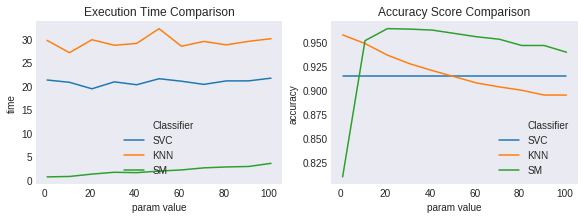

In [13]:
fig =  plt.figure(figsize=(6*g_ratio, 3))

sns.lineplot(x="param value", y="time", hue='Classifier', data=df, ax=fig.add_subplot(121))
plt.title("Execution Time Comparison")

sns.lineplot(x="param value", y="accuracy", hue='Classifier', data=df, ax=fig.add_subplot(122))
plt.title("Accuracy Score Comparison")

plt.show()

## 6. In depth comparison

Since we use an scikit-learn like API, we can utilize a lot of the samples that can be found on their website.

Here we will follow this [page](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html) to easily calculate the precision, recall, f1-score and confusion matrix for each model.

In [14]:
knnc = KNeighborsClassifier(n_neighbors=1)
knnc.fit(X_train, y_train)

svc = SVC(C=1, kernel='linear')
svc.fit(X_train, y_train)

smc = SubspaceMethod(n_subdims=30, faster_mode=True)
smc.fit(*format_input(X_train, y_train))
smc.classes_ = np.unique(y) # これいらないようにコード変える

Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       171
           1       0.95      1.00      0.97       222
           2       0.87      0.87      0.87       202
           3       0.86      0.89      0.87       202
           4       0.90      0.97      0.94       187
           5       0.88      0.88      0.88       187
           6       0.97      0.94      0.96       204
           7       0.95      0.89      0.92       214
           8       0.93      0.86      0.90       223
           9       0.89      0.87      0.88       188

    accuracy                           0.91      2000
   macro avg       0.91      0.92      0.91      2000
weighte

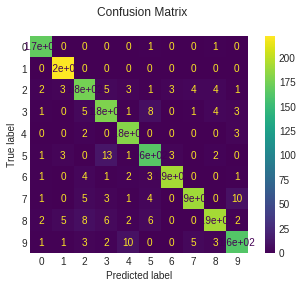

Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform'):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       171
           1       0.95      1.00      0.98       222
           2       0.97      0.93      0.95       202
           3       0.95      0.94      0.94       202
           4       0.94      0.96      0.95       187
           5       0.97      0.95      0.96       187
           6       0.98      0.99      0.98       204
           7       0.96      0.94      0.95       214
           8       0.96      0.92      0.94       223
           9       0.93      0.95      0.94       188

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000




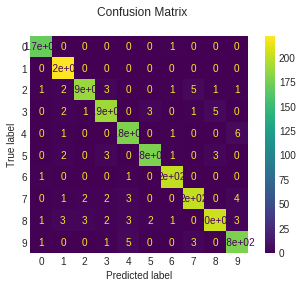

Classification report for classifier SubspaceMethod(n_subdims=30, normalize=False):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       171
           1       0.97      1.00      0.98       222
           2       0.96      0.95      0.95       202
           3       0.97      0.95      0.96       202
           4       0.97      0.98      0.98       187
           5       0.97      0.94      0.95       187
           6       0.99      0.98      0.98       204
           7       0.98      0.94      0.96       214
           8       0.92      0.96      0.94       223
           9       0.96      0.97      0.97       188

    accuracy                           0.96      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.96      0.96      2000




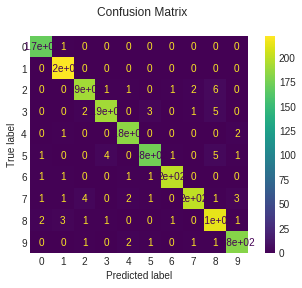

In [16]:
from sklearn import metrics


def plot_stats(classifier):
    y_pred = classifier.predict(X_test)
    disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
    disp.figure_.suptitle("Confusion Matrix")
    print("Classification report for classifier %s:\n%s\n"
          % (classifier, metrics.classification_report(y_test, y_pred)))
    plt.show()

plot_stats(svc)
plot_stats(knnc)
plot_stats(smc)